# Example Notebook for Network Visualization

### Change working directory to this root

In [1]:
import os
os.chdir("..")

### Imports

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import hydra

import models
import loaders

### Load model

In [3]:
# Infer device


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current device is {device}")

# Load network
with hydra.initialize(version_base=None, config_path="../config"):
    cfg = hydra.compose(config_name="config")
cfg.learning.batch_size = 128
weights_path = "saved/mnist_fcn.ckpt"
model = getattr(models, cfg.model.module).from_cfg(cfg, weights=weights_path).to(device).eval()

Current device is cuda


### Load data loader

In [4]:
data_module = getattr(loaders, cfg.data.type).from_cfg(cfg)
data_module.setup("val")
loader = data_module.val_dataloader()

### Load data point and visualize it

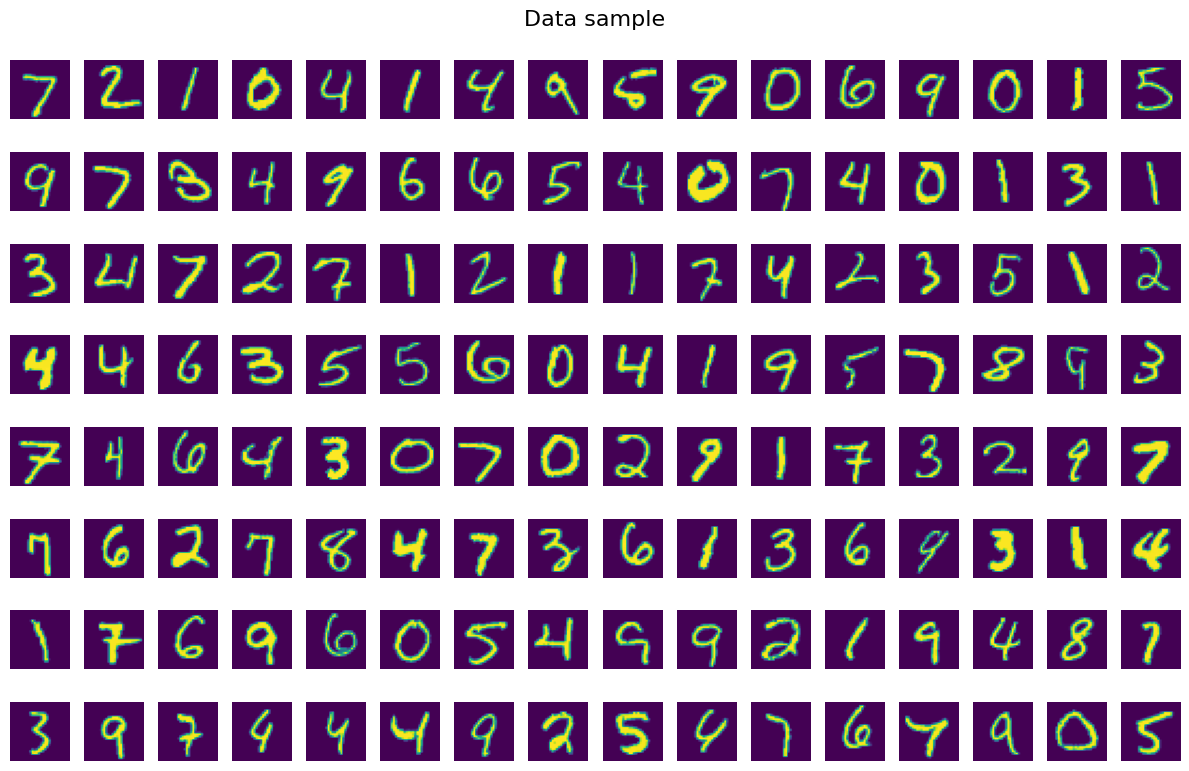

In [5]:
for batch in loader:
    images: torch.Tensor = batch["images"]
    break
image_reshaped = images.cpu().numpy() # type: ignore

n_rows = 8
n_cols = 16

# Create a figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
fig.suptitle('Data sample', fontsize=16)

for i in range(n_rows):
    for j in range(n_cols):
        index = i * n_cols + j
        if index < n_rows * n_cols:
            ax = axes[i, j]
            ax.axis('off')
            ax.imshow(image_reshaped[index, 0, ...])

plt.tight_layout()
plt.show()

## Inference

### Perform inference

In [6]:
batch = {key: value.to(device) for (key, value) in batch.items() if isinstance(value, torch.Tensor)}
with torch.no_grad():
    outputs = model.forward(batch)
logits = outputs["logits"]

n_rows = 8
n_cols = 16
size_factor = 2

# Create a figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * size_factor, n_rows * (size_factor + 0.5)))
fig.suptitle('Classification results', fontsize=32)

for i in range(n_rows):
    for j in range(n_cols):
        index = i * n_cols + j
        if index < n_rows * n_cols:
            ax = axes[i, j]
            ax.axis('off')
            ax.imshow(image_reshaped[index, 0, ...])
            
            
            # Calculate chance and show it in green if class is correct
            highest_prob_class = logits[index].argmax()
            highest_prob = F.softmax(logits[index], dim=0).max()
            title_color = 'green' if highest_prob_class == batch["class"][index] else 'red'
            
            ax.set_title(f'Class: {highest_prob_class}\nProb: {highest_prob:.3f}', fontsize=18, color=title_color)
            
plt.show()

KeyError: 'pred_logits'